# Finite potential Well

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(E, V):
    return np.sqrt(E) * np.tan(2 * np.arctan(np.sqrt(E) / (np.sqrt(V) + np.sqrt(V - E))) + np.sqrt(E) + 0.5 * np.pi) - np.sqrt(V - E)

In [3]:
Erange = np.linspace(1e-3, 100, 10000)
V = 100
fun = f(Erange, V)

Text(0.5, 0, 'Energy with a potential of V=100')

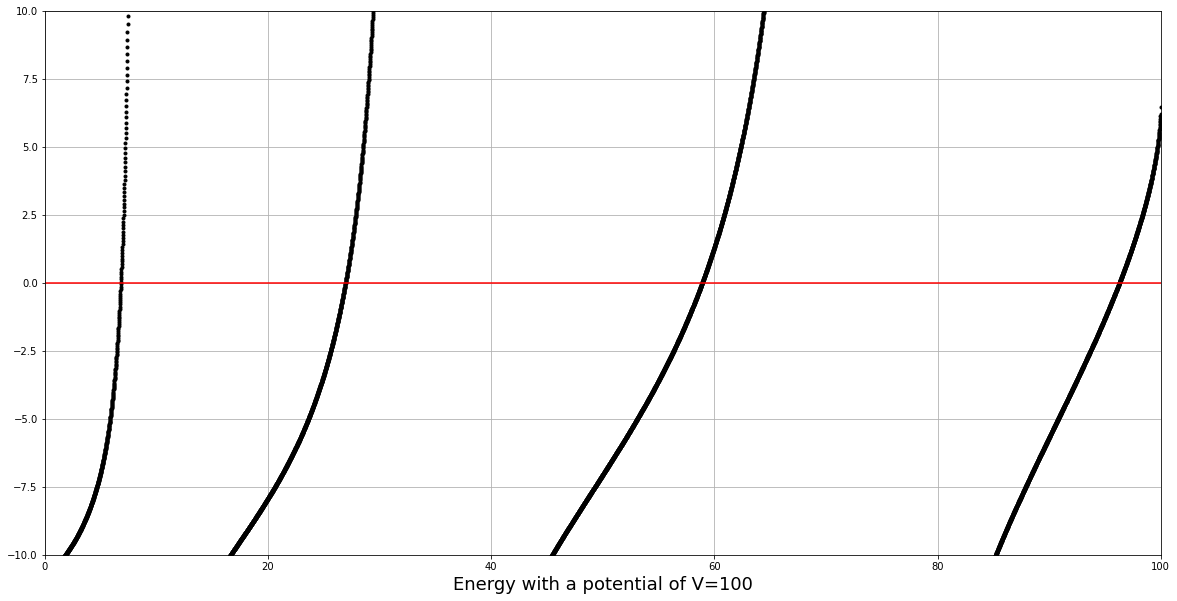

In [4]:
plt.figure(figsize=(20,10))
plt.plot(Erange, fun, 'k.')
plt.xlim([0, 100])
plt.ylim([-10, 10])
plt.grid()
plt.axhline(0, c='r')
plt.xlabel(f'Energy with a potential of V={V}', fontsize=18)

# Torus

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation

In [6]:
def slater(x, k):
    n = len(k)
    xx, kk = np.meshgrid(x, k)
    S = np.exp(1j * xx * kk)
    return S.T

def psi(x, k):
    S = slater(x, k)
    return 1 / np.sqrt(math.factorial(x.size)) * np.linalg.det(S)

def get_k(N, L):
    return np.array([2 * np.pi / L * (i + (N-1)/2) for i in range(1, N+1)])

In [7]:
gridsize = 100
x = np.linspace(0, 1, gridsize)
y = np.linspace(0, 1, gridsize)
xx, yy = np.meshgrid(x, y)
phi = 2 * np.pi * xx
theta = 2 * np.pi * yy
R = 1.5 # whole donut radius
r = 0.55 # radius of the donut's mass
surfacex = np.cos(theta) * (R + r * np.cos(phi))
surfacey = np.sin(theta) * (R + r * np.cos(phi))
surfacez = r * np.sin(phi)

In [8]:
k = get_k(2, 1)
Z = np.empty((gridsize, gridsize))
for i in tqdm(range(gridsize), total=gridsize):
    for j in range(gridsize):
        p = np.abs(psi(np.array([x[i], y[j]]), k))**2
        Z[i, j] = p

100%|██████████| 100/100 [00:00<00:00, 145.52it/s]


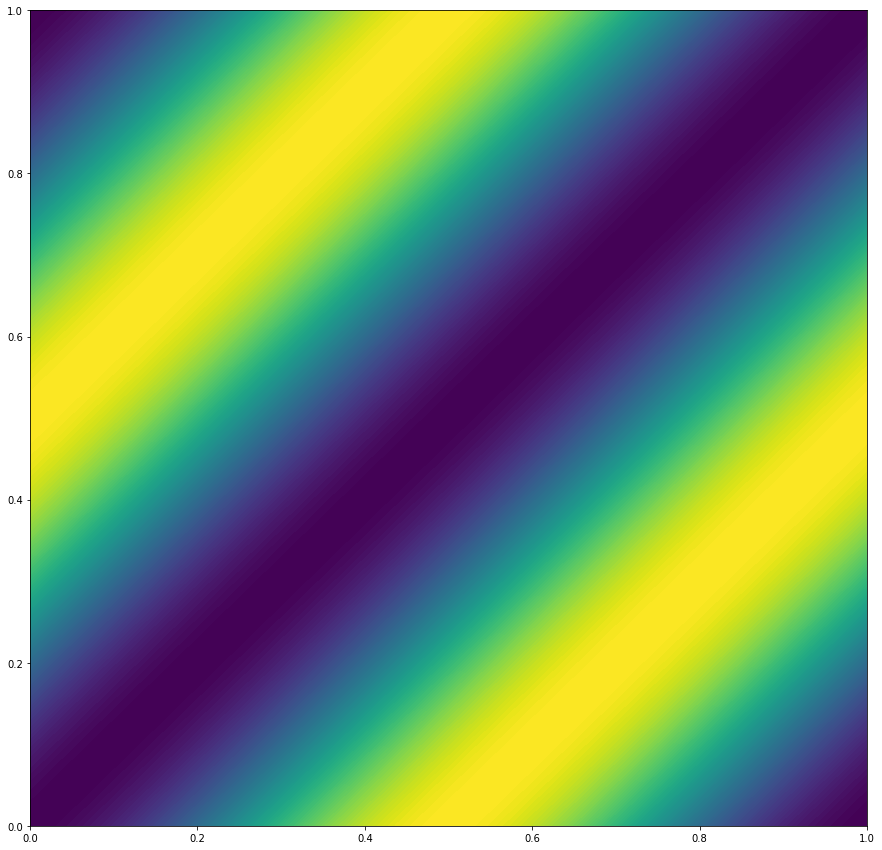

In [9]:
plt.figure(figsize=(15, 15))
plt.contourf(xx, yy, Z, levels=100);

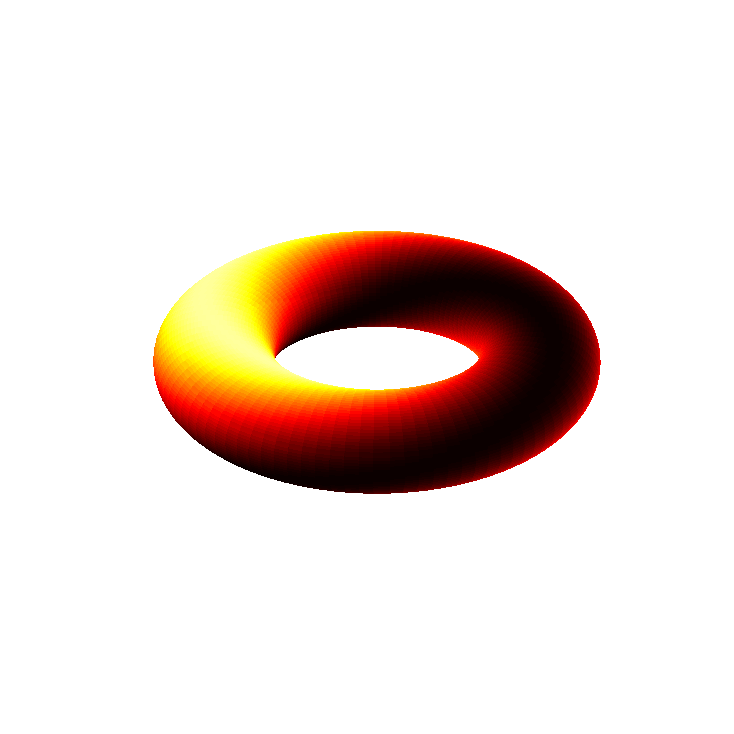

In [10]:
scaler = MinMaxScaler(feature_range=(0, 0.9))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot_surface(surfacex, surfacey, surfacez, facecolors=plt.cm.hot(scaler.fit_transform(Z)), antialiased=False, rstride=1, cstride=1, vmin=-1, vmax=2, shade=False)
lim = (max(abs(max(np.max(surfacex), np.max(surfacey), np.max(surfacez))), abs(min(np.min(surfacex), np.min(surfacey), np.min(surfacez)))))
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
plt.axis('off')

def rotate(angle):
     ax.view_init(azim=angle)
        
angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('torus_wavefunc.gif', writer=animation.PillowWriter(fps=20))

# The data!

In [1]:
from train_GMM import get_points_in_box
import tensorflow as tf
import sys
sys.path.append("../../DMAE")
sys.path.append("../../DMAE/examples/synthetic")
import DMAE
import vis_utils
import itertools
import numpy as np
import matplotlib.pyplot as plt

/home/vladimir/.local/share/virtualenvs/GMM-EM_LiebLiniger-CJETMew8/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
X = np.load("particle_positions_N=3_metro_steps=1000000_last_fixed.npz").T
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx][:10000]
X = get_points_in_box(X, 1)

X = np.float32(X[:, :2])
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)

In [3]:
# Number of clusters
n_clusters = 2
# Softmax inverse temperature parameter
alpha = 50
# Training parameters
batch_size = 256
epochs = 5
lr = 5e-4

In [4]:
def toroidal_dis(x_i, Y, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((x_i-Y+delta)**2, axis=1), d)
    return d

def toroidal_pairwise(X, Y, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_dis(x_i, Y, interval)
    Z = tf.vectorized_map(func, X)
    return Z

In [5]:
def toroidal_loss(X, mu_tilde, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((X-mu_tilde+delta)**2, axis=1), d)
    return d

In [6]:
interval = tf.constant((1.0, 1.0))
dis = lambda X, Y: toroidal_pairwise(X, Y, interval)
dmae_loss = lambda X, mu_tilde: toroidal_loss(X, mu_tilde, interval)

In [11]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 1),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
model.compile(loss=dmae_loss, optimizer=tf.optimizers.Adam(lr=lr))

In [12]:
history = model.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

In [10]:
train_loss = history.history['loss']
train_loss

[0.07157031446695328,
 0.06546314805746078,
 0.059261102229356766,
 0.0546630434691906,
 0.050811994820833206]

(0.0, 1.0)

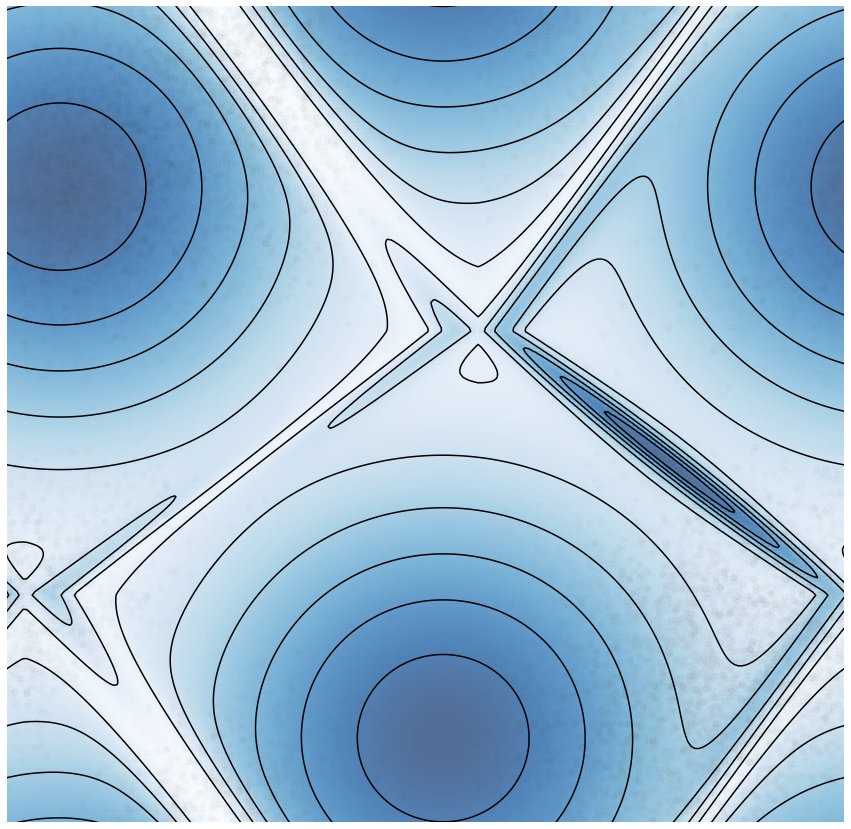

In [212]:
fig, ax = vis_utils.visualize_distribution(model, dmae_loss, 10, X, figsize=(15, 15))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [213]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=alpha, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

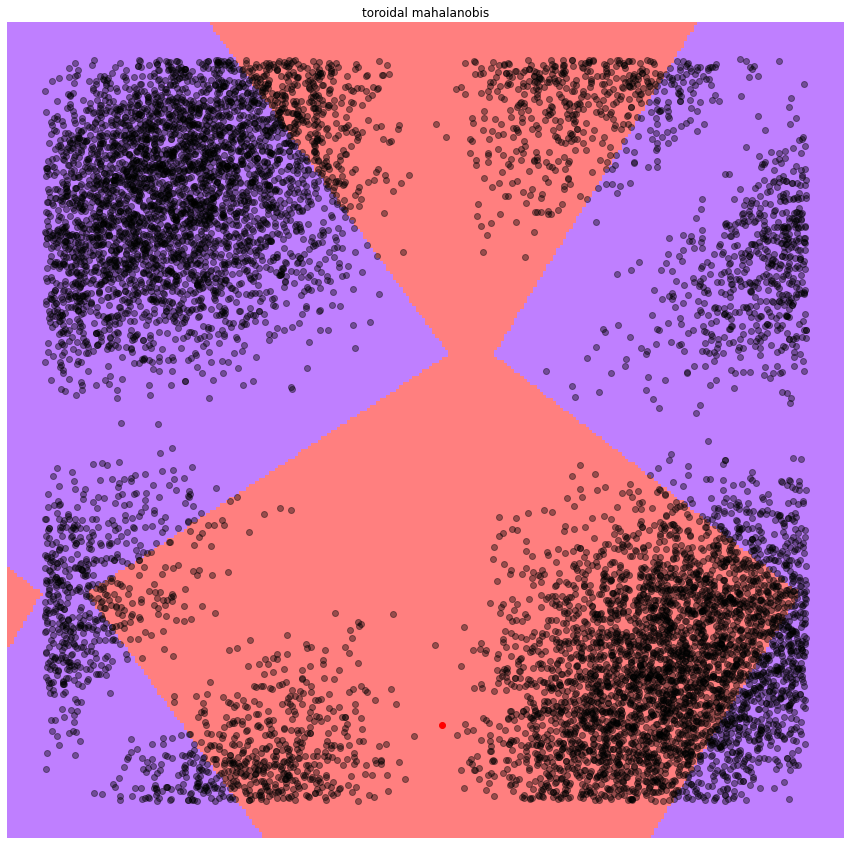

In [214]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal mahalanobis", X, (15, 15), batch_size)

In [215]:
def toroidal_mahalanobis(x_i, Y, cov, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(x_i-Y+delta, axis=-1)
        d = tf.minimum(tf.squeeze(tf.reduce_sum(tf.matmul(cov, diff)*diff, axis=1)), d)
    return d

def toroidal_mahalanobis_pairwise(X, Y, cov, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_mahalanobis(x_i, Y, cov, interval)
    Z = tf.vectorized_map(func, X)
    return Z

def toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        diff = tf.expand_dims(X-mu_tilde+delta, axis=1)
        d = tf.minimum(tf.squeeze(tf.matmul(tf.matmul(diff, Cov_tilde), tf.transpose(diff, perm = [0, 2, 1]))), d)
    return d

In [216]:
interval = tf.constant((1.0, 1.0))
dis = lambda X, Y, cov: toroidal_mahalanobis_pairwise(X, Y, cov, interval)
dmae_loss = lambda X, mu_tilde, Cov_tilde: toroidal_mahalanobis_loss(X, mu_tilde, Cov_tilde, interval)

In [217]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(alpha=alpha*10, n_clusters=n_clusters,
                                                             initializers={"centers": tf.keras.initializers.RandomUniform(0, 1),
                                                                           "cov": DMAE.Initializers.InitIdentityCov(X, n_clusters),
                                                                           "mixers": tf.keras.initializers.Constant(1.0)},
                                                             trainable = {"centers": True, "mixers": False, "cov": True},
                                                             dissimilarity=dis)(inp)
# DMAE model
model2 = tf.keras.Model(inputs=[inp], outputs=theta_tilde)

In [218]:
loss = dmae_loss(inp, *theta_tilde)
model2.add_loss(loss)
model2.compile(optimizer=tf.optimizers.Adam(lr=lr))

In [219]:
init_means = model.layers[-1].get_weights()[0]
original_params = model2.layers[1].get_weights()
model2.layers[1].set_weights([init_means, *original_params[1:]])

In [220]:
model2.fit(X, epochs=10, batch_size=batch_size)

Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.0519
Epoch 10/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0491


In [221]:
# 0.0235 -> 2 clusters
# 0.0178 -> 1 cluster
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(alpha=alpha*10, n_clusters=n_clusters,
                                                     dissimilarity=dis,
                                                     trainable={"centers": False, "mixers": False, "cov": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model2.layers[1].get_weights())

(0.0, 1.0)

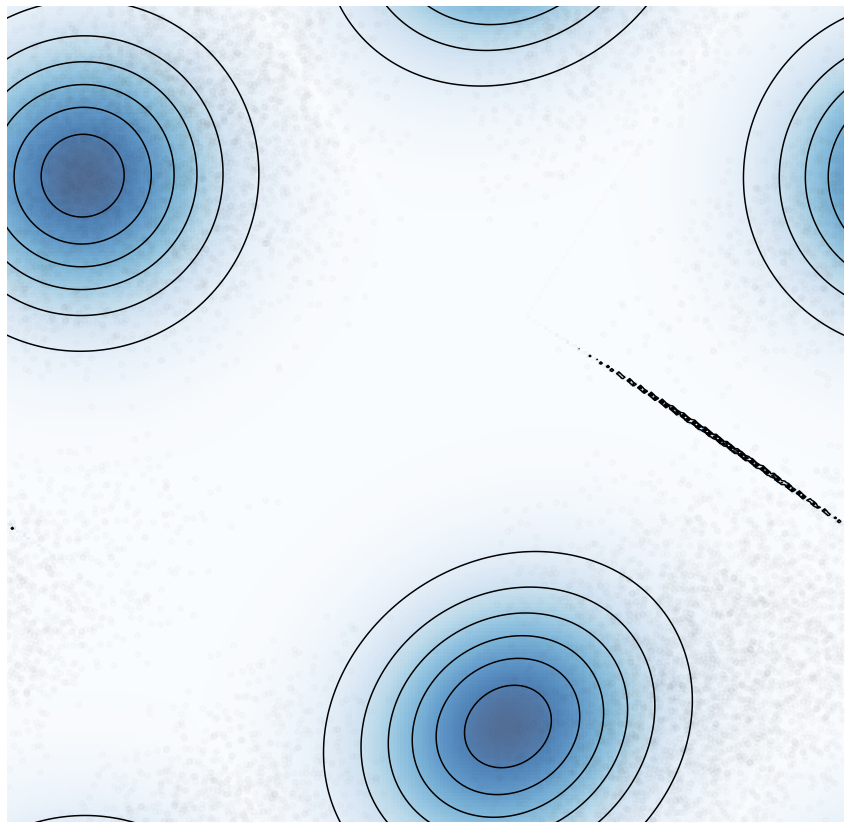

In [222]:
fig, ax = vis_utils.visualize_distribution(model2, dmae_loss, 50, X, figsize=(15, 15), cov=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [223]:
fig, ax = vis_utils.visualize_probas(DMAE_encoder, X, n_clusters, rows=1, cols=2, figsize=(20, 8))
for axi in ax:
    axi.set_xlim([0, 1])
    axi.set_ylim([0, 1])

Substituting symbol X from STIXNonUnicode
Substituting symbol X from STIXNonUnicode
Substituting symbol X from STIXNonUnicode
Substituting symbol X from STIXNonUnicode


In [224]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal mahalanobis", X, (15, 15), batch_size)